**株価データ（60日分）**を読み込む
**AR(1)モデル（自己回帰モデル）**を仮定する

Metropolis–Hastings法を使って
μ（平均）
φ（AR(1)係数）
σ（ばらつき）
の 事後分布をサンプリングする

得られたパラメータから 未来10日間の株価を予測
平均予測と不確実性（5–95%帯）を表示する

acceptance rate = 0.4805240262013101
posterior samples = 3000
mu mean = 82.67942514517037 phi mean = 0.9871542626565166 sigma mean = 0.9495724986453306


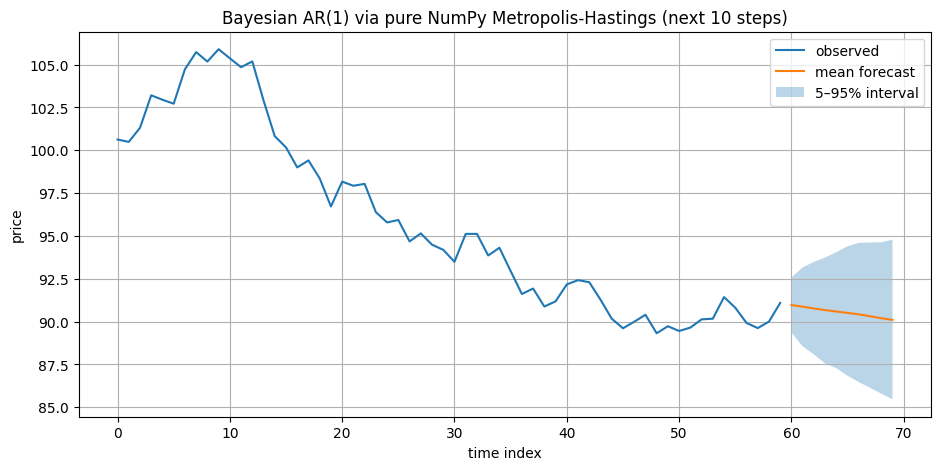

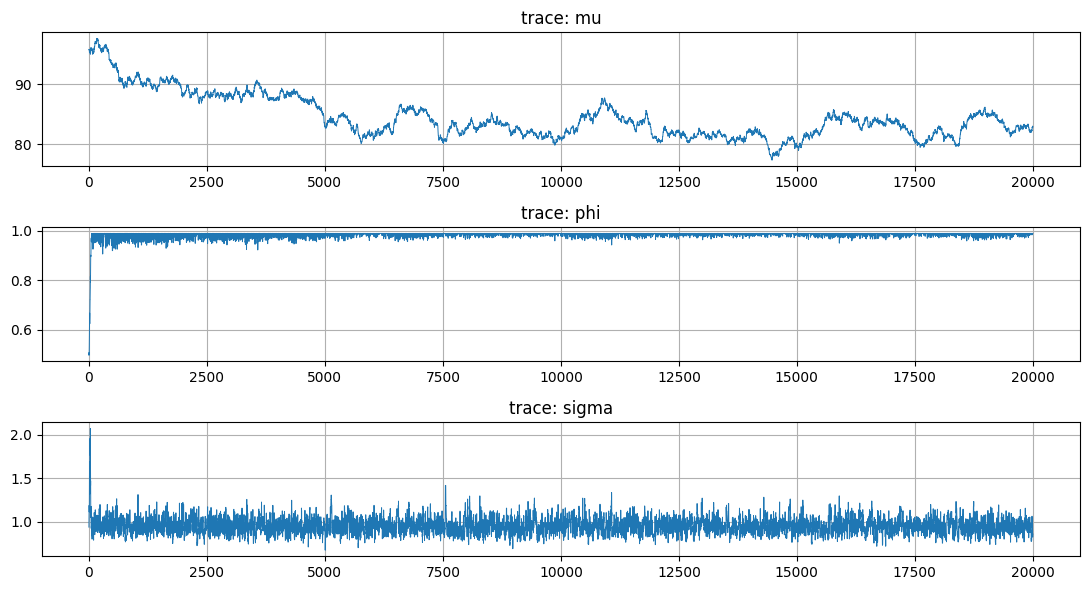

In [2]:
# ============================================================
# 完全版：NumPyだけの Metropolis-Hastings（純Python MCMC）
#   - C/C++ コンパイル不要
#   - PyTensor / PyMC 不要
#   - AR(1) をベイズ推定（mu, phi, sigma）
#   - 未来10ステップ予測（予測分布の帯）
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from io import StringIO

# ----------------------------
# 1) データ（架空の株価 60本）
# ----------------------------
csv_data = """date,close
2025-11-03,100.63
2025-11-04,100.49
2025-11-05,101.31
2025-11-06,103.21
2025-11-07,102.95
2025-11-10,102.72
2025-11-11,104.73
2025-11-12,105.73
2025-11-13,105.18
2025-11-14,105.90
2025-11-17,105.37
2025-11-18,104.85
2025-11-19,105.19
2025-11-20,102.91
2025-11-21,100.82
2025-11-24,100.17
2025-11-25,99.00
2025-11-26,99.41
2025-11-27,98.36
2025-11-28,96.72
2025-12-01,98.17
2025-12-02,97.93
2025-12-03,98.04
2025-12-04,96.39
2025-12-05,95.79
2025-12-08,95.93
2025-12-09,94.68
2025-12-10,95.15
2025-12-11,94.49
2025-12-12,94.19
2025-12-15,93.49
2025-12-16,95.12
2025-12-17,95.12
2025-12-18,93.86
2025-12-19,94.31
2025-12-22,92.95
2025-12-23,91.61
2025-12-24,91.93
2025-12-25,90.88
2025-12-26,91.18
2025-12-29,92.17
2025-12-30,92.42
2025-12-31,92.30
2026-01-01,91.28
2026-01-02,90.17
2026-01-05,89.61
2026-01-06,89.99
2026-01-07,90.40
2026-01-08,89.32
2026-01-09,89.73
2026-01-12,89.45
2026-01-13,89.65
2026-01-14,90.13
2026-01-15,90.17
2026-01-16,91.43
2026-01-19,90.81
2026-01-20,89.92
2026-01-21,89.62
2026-01-22,90.00
2026-01-23,91.09
"""

# pandas不要のCSVパース（2列目だけ拾う）
lines = csv_data.strip().splitlines()[1:]
y = np.array([float(line.split(",")[1]) for line in lines], dtype=float)

y_prev = y[:-1]
y_next = y[1:]

# ----------------------------
# 2) モデル：AR(1)
#   y_t ~ Normal(mu + phi*(y_{t-1}-mu), sigma)
# ----------------------------
def log_likelihood(mu, phi, sigma):
    if sigma <= 0:
        return -np.inf
    pred = mu + phi * (y_prev - mu)
    resid = y_next - pred
    n = resid.size
    return -0.5 * (np.sum((resid / sigma) ** 2) + n * np.log(2 * np.pi * sigma * sigma))

# ----------------------------
# 3) 事前分布（弱情報）
#   mu ~ Normal(mean(y), 50)
#   phi ~ Uniform(-0.99, 0.99)
#   sigma ~ HalfNormal(10)  （対数で書く）
# ----------------------------
def log_prior(mu, phi, sigma):
    if not (-0.99 <= phi <= 0.99):
        return -np.inf
    if sigma <= 0:
        return -np.inf

    mu0 = float(np.mean(y))
    mu_sd = 50.0
    lp_mu = -0.5 * (((mu - mu0) / mu_sd) ** 2 + np.log(2 * np.pi * mu_sd * mu_sd))

    # phi: 一様（範囲内なら定数、範囲外は -inf）
    lp_phi = -np.log(0.99 - (-0.99))

    # sigma: HalfNormal(scale=10)
    s0 = 10.0
    # half-normal: p(s) = sqrt(2/pi)/s0 * exp(-s^2/(2 s0^2)), s>0
    lp_sigma = np.log(np.sqrt(2/np.pi) / s0) - 0.5 * (sigma / s0) ** 2

    return lp_mu + lp_phi + lp_sigma

def log_posterior(mu, phi, sigma):
    lp = log_prior(mu, phi, sigma)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(mu, phi, sigma)
    return lp + ll

# ----------------------------
# 4) Metropolis-Hastings (ランダムウォーク)
# ----------------------------
rng = np.random.default_rng(0)

N = 20000
burn = 5000
thin = 5

# 提案分布の幅（受理率が低い/高いなら調整）
mu_step = 0.15
phi_step = 0.03
sigma_step = 0.10

mu_chain = np.empty(N)
phi_chain = np.empty(N)
sigma_chain = np.empty(N)

# 初期値
mu_chain[0] = float(np.mean(y))
phi_chain[0] = 0.5
sigma_chain[0] = float(np.std(np.diff(y))) if np.std(np.diff(y)) > 1e-6 else 1.0

cur_mu, cur_phi, cur_sigma = mu_chain[0], phi_chain[0], sigma_chain[0]
cur_lp = log_posterior(cur_mu, cur_phi, cur_sigma)

accept = 0

for t in range(1, N):
    # 提案
    prop_mu = cur_mu + rng.normal(0, mu_step)
    prop_phi = np.clip(cur_phi + rng.normal(0, phi_step), -0.99, 0.99)

    # sigmaは正に保つ（対数スケール提案の方が安定）
    prop_log_sigma = np.log(cur_sigma) + rng.normal(0, sigma_step)
    prop_sigma = np.exp(prop_log_sigma)

    prop_lp = log_posterior(prop_mu, prop_phi, prop_sigma)

    if np.log(rng.random()) < (prop_lp - cur_lp):
        cur_mu, cur_phi, cur_sigma = prop_mu, prop_phi, prop_sigma
        cur_lp = prop_lp
        accept += 1

    mu_chain[t] = cur_mu
    phi_chain[t] = cur_phi
    sigma_chain[t] = cur_sigma

acc_rate = accept / (N - 1)
print("acceptance rate =", acc_rate)

# ----------------------------
# 5) 事後サンプル（バーンイン＆間引き）
# ----------------------------
idx = np.arange(burn, N, thin)
mu_s = mu_chain[idx]
phi_s = phi_chain[idx]
sigma_s = sigma_chain[idx]

print("posterior samples =", len(mu_s))
print("mu mean =", mu_s.mean(), "phi mean =", phi_s.mean(), "sigma mean =", sigma_s.mean())

# ----------------------------
# 6) 未来10ステップ予測（事後予測分布）
# ----------------------------
steps = 10
M = min(2000, len(mu_s))  # 予測に使うサンプル数（軽量化）

pick = rng.choice(len(mu_s), size=M, replace=False)
mu_p = mu_s[pick]
phi_p = phi_s[pick]
sigma_p = sigma_s[pick]

future = np.empty((M, steps), dtype=float)

for i in range(M):
    x = y[-1]
    for k in range(steps):
        x = rng.normal(mu_p[i] + phi_p[i] * (x - mu_p[i]), sigma_p[i])
        future[i, k] = x

mean_pred = future.mean(axis=0)
p5 = np.percentile(future, 5, axis=0)
p95 = np.percentile(future, 95, axis=0)

# ----------------------------
# 7) 可視化
# ----------------------------
t_obs = np.arange(len(y))
t_fut = np.arange(len(y), len(y) + steps)

plt.figure(figsize=(11, 5))
plt.plot(t_obs, y, label="observed")
plt.plot(t_fut, mean_pred, label="mean forecast")
plt.fill_between(t_fut, p5, p95, alpha=0.3, label="5–95% interval")
plt.title("Bayesian AR(1) via pure NumPy Metropolis-Hastings (next 10 steps)")
plt.xlabel("time index")
plt.ylabel("price")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 8) おまけ：チェーンの簡易診断プロット（任意）
# ----------------------------
plt.figure(figsize=(11, 6))
plt.subplot(3,1,1)
plt.plot(mu_chain, linewidth=0.7)
plt.title("trace: mu")
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(phi_chain, linewidth=0.7)
plt.title("trace: phi")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(sigma_chain, linewidth=0.7)
plt.title("trace: sigma")
plt.grid(True)

plt.tight_layout()
plt.show()
